# Welcome to Silicon
What is Silicon and why should you care? In one sentence, Silicon is a Python framework that promises a wildly more productive way of developing RTL code for FPGAs and ASICs. There are several ways to think about how Silicon achieves this.

You can think of Silicon as a new RTL language, one that is based on Python.
You can think of Silicon as a Python-based RTL generator.
You can also think of Silicon as library of tools to describe data-flow graphs, one application of which is to generate RTL.


The most important features of Silicon are:
1. Silicon contains a full event-driven simulation engine, that can generate VCD files. No need to use expensive, license-only simulators to see how your design is behaving
2. Silicon clearly isolates synthesis from simulation. This makes it clear what language features are available in what context
3. Silicon interfaces with synthesis tools by generating SystemVerilog RTL. It attempts to create as human-readable RTL as possible. This should help in co-design, because, let's face it: even if you whole-heartedly embrace Silicon, much of your design work-flow will depend on 3rd party RTL pieces written in Verilog, VHDL or some other language.
4. The design of Silicon allows for library development of higher and higher abstractions without braking the workflow or requiring obnoxious syntax for the use of library modules. 

The most important design principles of Silicon are:
1. Silicon uses an 'invocation is instantiation' paradigm: most module instances are created through simple function-call-looking constructs (even though under the hood they are not).
2. Silicon describes data flow. At the end of the day, you use Python to create a data-flow-graph, represented by Silicon objects. There is no control flow in the traditional sense. You can't write an 'if-then-else' statement and have silicon generate the associated multiplexer for you.
3. Silicon uses a range-tracking type to represent wires and buses.
4. Silicon uses a type-propagation system to determine types of nets within your design. This is not infallible, and you can provide typing information to help it along, but it allows for a high level of generic description on the problem at hand.

# The building blocks
The end goal of a Silicon design is to generate a `netlist`. A `netlist` is generated from a single 'top' design entity. Design entities in Silicon are called `Module`s, the same nomenclature that Verilog is using.

A `Module` normally contains sub-module instances and connecting `Net`s. There are of course `Input` and `Output` `Ports` on every module, which defines their interface to the external world.

These modules and their sub-modules define the design hierarchy. At the bottom of the hierarchy are modules which don't instantiate any sub-modules. These are primitive modules.

There are of course a lot of additional details, but really, at the very basic level, that's it. Everything, and I do mean *everything* is described in Silicon by a set of module instances, connected by nets, packaged into a module hierarchy.

This is quite a bit different from both VHDL and Verilog (not to mention HDL languages) which all to a certain degree try to 'compile' code into a netlist, but it gives a function feel to Silicon descriptions of networks. Enough words, though, let's look at an example!


# A full adder
Our first example is going to be to create (and test) a full adder. I'm not going to describe what the circuit is supposed to do, if you need an explanation, you can find it [here](https://en.wikipedia.org/wiki/Adder_(electronics)).

The first thing we need to do, is to import the Silicon library. (I'm going to import it as a namespace so it's clear where do I use something from Silicon but of course that's a matter of taste largely.)

In [1]:
# Only need to change the path if using a local version of Silicon
import sys
sys.path.append("..")

In [2]:
import silicon as si

Now, we can create our module. We start by describing the interface:

In [3]:
class FullAdder(si.Module):
    in_a = si.Input(si.logic)
    in_b = si.Input(si.logic)
    in_c = si.Input(si.logic)
    out_r = si.Output(si.logic)
    out_c = si.Output(si.logic)

There are a few things happening here, so let's break it down:

Every module in Silicon inherits (in some way) from the `Module` class. In many cases, maybe even most cases, you do actually inherit from `Module`, though class hierarchies are possible. It appears to me though that containment (sub-modules if you wish) is a better model for RTL then inheritance.

Next, we declare all of our inputs (`in_a`, `in_b` and `in_c`) and outputs (`out_r` and `out_c`). These turn into class-attributes in Python parlance, but some under-the-hood tricks will create copies of all of them for each instance (object created from `FullAdder`). These together are called the ports of the module.

All module ports are objects of `Input` or `Output` classes. (There are a few others, but most importantly, there's no input-output port. The direction of the data-flow on every port is well-defined and uni-directional.)

Finally, each port has a type associated with it, in this case, the single-bit `logic` type.

With that, we can move on to the actual implementation (the body) of our module:

In [4]:
class FullAdder(si.Module):
    in_a = si.Input(si.logic)
    in_b = si.Input(si.logic)
    in_c = si.Input(si.logic)
    out_r = si.Output(si.logic)
    out_c = si.Output(si.logic)
    
    def body(self):
        self.out_r <<= self.in_a ^ self.in_b ^ self.in_c
        self.out_c <<= (self.in_a & self.in_b) | (self.in_b & self.in_c) | (self.in_c & self.in_a)


The actual logic of course is well known and really simple, so let's call out a couple of syntactic peculiarities:

1 Logical operations are overloaded versions of the Python built-in operators: `&` `|` and `^` in this case.
2 To bind an expression (well see what this means in a minute) to a port, we use the `<<=` operator.

What can we do with this thing though? For one, we can generate RTL from it:

In [5]:
top = FullAdder()
netlist = si.elaborate(top)
rtl = si.StrStream()
netlist.generate(netlist, si.SystemVerilog(rtl))
print(rtl)

////////////////////////////////////////////////////////////////////////////////
// FullAdder
////////////////////////////////////////////////////////////////////////////////
module FullAdder (
	input logic in_a,
	input logic in_b,
	input logic in_c,
	output logic out_r,
	output logic out_c
);

	assign out_r = in_a ^ in_b ^ in_c;
	assign out_c = in_a & in_b | in_b & in_c | in_c & in_a;

endmodule





Nothing really magical, maybe the only thing to point out is that generated RTL is easy to read and pretty much what you would have coded up by hand. While of course there are limitations, this is one of the guiding principles of Silicon: keep generated RTL as easy to read as possible.

Another thing we can do is to simulate and test the design. For that, of course we'll need to create a test-bench. There are two main ways of going about it. The traditional Verilog way would be to create another module that instantiates the DUT (our full adder), drives its inputs and examines its outputs. We can do that in Silicon too. In some cases however it's easier to simply inherit from the DUT module and write the tests in this test module. I'm going to show this later method here:

In [6]:
class FullAdder_tb(FullAdder):
    def simulate(self):
        for i in range(8):
            expected_sum = (i & 1) + (i >> 1 & 1) + (i >> 2 & 1)
            print(f"Testing case {i} with expected sum {expected_sum}")
            self.in_a <<= (i & 1) != 0
            self.in_b <<= (i & 2) != 0
            self.in_c <<= (i & 4) != 0
            yield 10
            print(f"\tReturned self.out_r:{self.out_r.sim_value} self.out_c:{self.out_c.sim_value}")
            assert self.out_r == expected_sum & 1
            assert self.out_c == expected_sum >> 1 & 1
        print("Pass")


Let's unpack this!

First of all, notice that for simulation purposes, we use a different method (`simulate`) instead of `body` that we've used for synthesis. This clearly separates the two contexts and what can and cannot be done in each. If a module has both of these methods, the content of `simulate` will be used for simulations, and the content of `body` will be used for synthesis. In most cases either one or the other exists on any particular module.

Another important feature to notice is the `yield 10` statement. This advances the simulation time by 10 ticks (ns by default). All statements between yields occur at the same simulated time. This should look very familiar from other RTL languages, Verliog uses the @ construct in the same way: the values of nets only update when simulation time advances, not when the assignment is made. It is also the time, when sensitivity lists are evaluated and and their associated actions are taken. In other words, no yield -> nothing happens.

This is one of the major differences between synthesis and simulation or between the bodies of `body` and `simulate`: `body` only describes the netlist. It creates a static data-flow graph, it never *ever* talks about the passage of time. In contrast, `simulate` *must* advance time, otherwise nothing happens. Simulation is only useful in the context of time. This is the act of breeze life if you wish into the static data-flow graph described in `body`.

You can see how many of Pythons control-flow constructs are used in `simulate`. We created a `for` loop, we've used `assert`s. These of course make perfect sense in a simulation environment: control flow is inherently a time-dependent phenomena.

It's worth mentioning the second `print` statement: it accesses he current simulation value of the two output ports, by using the `sim_value` attribute. This is because the default string representation of ports is way too verbose for our purposes here.


We can finally use this module as the top level for our simulation run:

In [7]:
top = FullAdder_tb()
netlist = si.elaborate(top)
vcd_filename = "full_adder.vcd"
netlist.simulate(vcd_filename)

Testing case 0 with expected sum 0
	Returned self.out_r:0 self.out_c:0
Testing case 1 with expected sum 1
	Returned self.out_r:1 self.out_c:0
Testing case 2 with expected sum 1
	Returned self.out_r:1 self.out_c:0
Testing case 3 with expected sum 2
	Returned self.out_r:0 self.out_c:1
Testing case 4 with expected sum 1
	Returned self.out_r:1 self.out_c:0
Testing case 5 with expected sum 2
	Returned self.out_r:0 self.out_c:1
Testing case 6 with expected sum 2
	Returned self.out_r:0 self.out_c:1
Testing case 7 with expected sum 3
	Returned self.out_r:1 self.out_c:1
Pass


80

In case you are wondering, yes a VCD file is also dumped that you can visualize using GTKWave among other things:

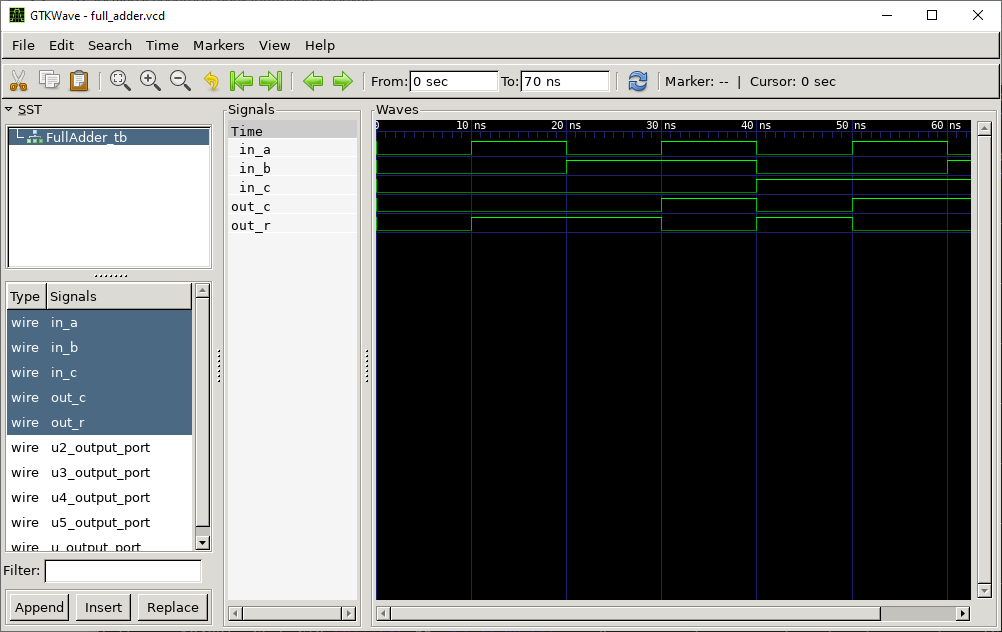

# A slightly deeper dive
Let's turn our attention back to the body of our full adder:

In [8]:
class FullAdder(si.Module):
    in_a = si.Input(si.logic)
    in_b = si.Input(si.logic)
    in_c = si.Input(si.logic)
    out_r = si.Output(si.logic)
    out_c = si.Output(si.logic)
    
    def body(self):
        self.out_r <<= self.in_a ^ self.in_b ^ self.in_c
        self.out_c <<= (self.in_a & self.in_b) | (self.in_b & self.in_c) | (self.in_c & self.in_a)


Remember, that I've said that Silicon really is just a Matrioshka doll of modules inside modules inside modules. Yet, what I'm showing here is are two rather straight-forward expressions. I've also said that `body` is a static description of a data-flow graph, yet it sure looks like we're evaluating values. So what gives?

To understand how there is no contradiction here, we'll have to dig a little deeper, and see what's under the hood. Python allows for operator overload and Silicon uses that heavily. Each of these operators are replaced by instantiations of simple gates. It is equivalent to the following:

In [9]:
class FullAdder(si.Module):
    in_a = si.Input(si.logic)
    in_b = si.Input(si.logic)
    in_c = si.Input(si.logic)
    out_r = si.Output(si.logic)
    out_c = si.Output(si.logic)
    
    def body(self):
        self.out_r <<= si.xor_gate(si.xor_gate(self.in_a, self.in_b), self.in_c)
        self.out_c <<= si.or_gate(
            si.or_gate(si.and_gate(self.in_a, self.in_b), si.and_gate(self.in_b, self.in_c)), 
            si.and_gate(self.in_c, self.in_a)
        )


We can run another synthesis to see that that's true:

In [10]:
top = FullAdder()
netlist = si.elaborate(top)
rtl = si.StrStream()
netlist.generate(netlist, si.SystemVerilog(rtl))
print(rtl)

////////////////////////////////////////////////////////////////////////////////
// FullAdder
////////////////////////////////////////////////////////////////////////////////
module FullAdder (
	input logic in_a,
	input logic in_b,
	input logic in_c,
	output logic out_r,
	output logic out_c
);

	assign out_r = in_a ^ in_b ^ in_c;
	assign out_c = in_a & in_b | in_b & in_c | in_c & in_a;

endmodule





The final piece in the puzzle is that in Silicon (most) function-calls - or rather, things that look like function calls - are actually module instantiations. So the construct:

```
si.xor_gate(self.in_a, self.in_b)
```

really means 'instantiate an `xor_gate` module, bind it's first input to `self.in_a`, bind it's second input to `self.in_b` and return it's output (port object)'.

It follows that the outer `xor_gate` in the same line then binds its first input to the output of the inner `xor_gate`, the second input to `self.in_c` and returns its output port object.

Finally, the `<<=` operator really just takes what's on the right-hand side (which at this point is the output port object of the outer `xor_gate`) and binds it to what is on its left-hand side (in this case `self.out_r`).

In other words, these two lines of code within the `body` of `FullAdder` actually instantiated eight sub-modules and hooked their inputs and outputs together. No evaluation, no mention of time. Just a plain data-flow graph description of the computation to be performed *at a later time*, during simulation.

There are two important take-aways here:

1. Even though in many cases you will write expressions very similar to - say - Verilog, they mean very different things: they instantiate sub-modules and create small networks of them *directly*. There's no compilation happening other then what the Python interpreter provides. Just the creation of modules and the binding of their ports

2. In both Verilog and VHDL module instantiation and inference are very different processes with very different syntax. In Silicon there is just one thing: instantiation.

The end-result of this is that the language is highly expendable and modular. It really allows the development of higher abstractions and the creation of module libraries that integrate seamlessly with existing modules and work-flows. This statement might not be obvious at this point but we'll see examples of it later.